# Verifying the Li-Stephens Model inference of the jump rate

This notebook explores a verification of the Li-Stephens Model implementation. Specifically we focus on: (1) estimation of the haplotype copying jump rate when the error rate is given and (2) joint estimation of the jump-rate and the error probability.

For the joint estimation of the jump-rate and the error probability we are able to obtain the standard errors of each estimate as well by taking the square root of the diagonal of the Hessian matrix. In the case of the marginal jump rate estimation the error probability was $\epsilon = 10^{-2}$.

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../src/')
from plot_utils import *

%matplotlib inline

In [29]:
# Reading in the CSV of results from our various simulations ... 
results_csv = '../../results/ls_verify/ls_simulations_100.csv'
ls_verify_df = pd.read_csv(results_csv)
ls_verify_df.head()

,scales_true,scales_marg_hat,scales_jt_hat,eps_jt_hat,se_scales_jt_hat,se_eps_jt_hat
0,100,123.410428,104.132689,0.5,1.592690,0.000145
1,200,222.028817,184.699748,0.5,2.018281,0.000342
2,300,306.879880,228.793858,0.5,1.000000,1.000000
3,400,402.457213,294.515292,0.5,2.966379,0.001375
4,500,455.303159,291.618439,0.5,2.813957,0.001792


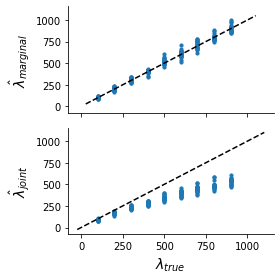

In [28]:
fig, ax = plt.subplots(2,1,figsize=(4,4), sharex=True, sharey=True)
ax[0].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_marg_hat'].values, s=10);

ax[1].scatter(ls_verify_df['scales_true'].values, 
           ls_verify_df['scales_jt_hat'].values, s=10);

plot_yx(ax[0], linestyle='--', color='black')
plot_yx(ax[1], linestyle='--', color='black')


ax[1].set_xlabel(r'$\lambda_{true}$', fontsize=14);
ax[1].set_ylabel(r'$\hat{\lambda}_{joint}$', fontsize=14);
ax[0].set_ylabel(r'$\hat{\lambda}_{marginal}$', fontsize=14);

debox(ax[0]); debox(ax[1]);
fig.tight_layout();